In [1]:
from PIL import Image
from pillow_heif import register_heif_opener
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms 
import time
import random

register_heif_opener()

image = Image.open('data/IMG_1432_FULL.HEIC')

print(image.size)
print(image.mode)

(4071, 959)
RGB


In [2]:
DEVICE = 'mps'

transform = transforms.Compose([ 
    transforms.PILToTensor() 
])

img_tensor = transform(image)
img_tensor = img_tensor.to(torch.float) / 255.0

print(img_tensor.shape) # (C, H, W)

torch.Size([3, 959, 4071])


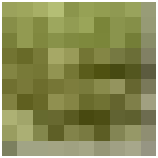

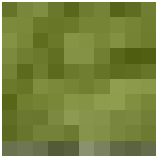

In [3]:
import matplotlib.pyplot as plt
def display_image(image, area=None, dpi=80):
    full_width = image.shape[2]
    full_height = image.shape[1]
        
    # display the image
    x = image.permute(1, 2, 0)
    
    # if there is an area specified, show that area zoomed. otherwise show the image
    dpi = dpi if area is None else 20
    figsize = (full_width / dpi, full_height / dpi) if area is None else (area[1] - area[0], area[3] - area[2])
        
    if area is not None:
        x = x[area[0]:area[1], area[2]:area[3], :]
        
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(x)
    plt.axis('off')
    plt.show()

# inspect the edges of the image. there seem to be some artifacts showing up after convolution
display_image(img_tensor, (img_tensor.shape[1] - 10, img_tensor.shape[1], img_tensor.shape[2] - 10, img_tensor.shape[2]))
display_image(img_tensor, (img_tensor.shape[1] - 10, img_tensor.shape[1], 0, 10))

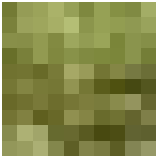

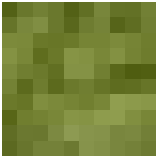

In [4]:
# clip the bottom and right 1-pixel edge as it contains random grey pixels (compression artifact?)
img_tensor = img_tensor[:, :-1, :-1]
# display again and make sure it is fixed
display_image(img_tensor, (img_tensor.shape[1] - 10, img_tensor.shape[1], img_tensor.shape[2] - 10, img_tensor.shape[2]))
display_image(img_tensor, (img_tensor.shape[1] - 10, img_tensor.shape[1], 0, 10))

In [5]:
IMAGE_CHANNELS = 3
SLICES = 100

# calculate slice width
slice_width = img_tensor.shape[2] // SLICES
slice_height = img_tensor.shape[1]
slice_shape = (IMAGE_CHANNELS, slice_height, slice_width)
flat_slice_size = IMAGE_CHANNELS * slice_width * slice_height

In [6]:
hidden_size = flat_slice_size // 400
latent_size = hidden_size // 4

print(f'Slice Shape: {slice_shape}')
print(f'Flat Size: {flat_slice_size}')
print(f'Hidden Size: {hidden_size}')
print(f'Latent Size: {latent_size}')

# encoder portion. will take our slices and (learn to) encode them into the latent space
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.input_layer = nn.Linear(flat_slice_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, latent_size)
        self.var = nn.Linear(hidden_size, latent_size)
        self.relu = nn.ReLU()
        self.norm1 = nn.LayerNorm([hidden_size])
        self.norm2 = nn.LayerNorm([hidden_size])
        
    def forward(self, x):
        x = self.relu(self.norm1(self.input_layer(x)))
        x = self.relu(self.norm2(self.hidden_layer(x)))
        mean = self.mean(x)
        log_variance = self.var(x)
        
        return mean, log_variance

# decoder portion. takes data that is normally distributed in the latent space
# and decodes to the input space
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.latent_in = nn.Linear(latent_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, flat_slice_size)
        self.norm1 = nn.LayerNorm([hidden_size])
        self.norm2 = nn.LayerNorm([hidden_size])
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.norm1(self.latent_in(x)))
        x = self.relu(self.norm2(self.hidden_layer(x)))
        x = self.output_layer(x)
        x = self.sigmoid(x)
        
        return x
    
# puts it all together and adds the reparameterization trick to 
# establish the Gaussian distribution
class VAETrainingModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAETrainingModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def reparameterize(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        return mean + epsilon * var
        
    def forward(self, x):
        mean, log_var = self.encoder(x)
        x = self.reparameterize(mean, log_var)
        x = self.decoder(x)
        
        return x, mean, log_var
    
def cost_function(x, x_pred, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_pred, x)
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Slice Shape: (3, 958, 40)
Flat Size: 114960
Hidden Size: 287
Latent Size: 71


In [7]:
BATCH_SIZE = 10
EPOCH_ITERS = img_tensor.shape[2] // slice_width // BATCH_SIZE
MODEL_WEIGHTS_FILE = 'out/model.pt'

# train the model on the flattened data
def train_model(model, next_batch, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_loss = np.inf
    best_epoch = 0

    phases = ['train', 'val']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # iterate 
            for _ in range(EPOCH_ITERS):
                inputs = next_batch(BATCH_SIZE)
                # Important! We need to flatten every datapoint to be
                # compatible with our model!
                inputs = inputs.to(DEVICE)
                # our targets are the same as our inputs!
                targets = inputs.to(DEVICE)
                # print(inputs.shape)
                # print(targets.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    x_pred, mean, log_var = model(inputs)
                    # print(outputs.shape)
                    loss = criterion(targets, x_pred, mean, log_var)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / BATCH_SIZE
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # save the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              with open(MODEL_WEIGHTS_FILE, 'wb') as f:
                torch.save(model.state_dict(), f)

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_FILE, map_location=DEVICE))

    return model, training_curves

In [8]:
LEARNING_RATE = 1e-3

encoder = Encoder().to(DEVICE)
print('Encoder: ', sum(p.numel() for p in encoder.parameters())/1e6, 'M parameters')
decoder = Decoder().to(DEVICE)
print('Decoder: ', sum(p.numel() for p in decoder.parameters())/1e6, 'M parameters')
training_model = VAETrainingModel(encoder, decoder).to(DEVICE)

optimizer_ = torch.optim.AdamW(training_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler_ = torch.optim.lr_scheduler.ExponentialLR(optimizer_, gamma=0.95)

Encoder:  33.118507 M parameters
Decoder:  33.212948 M parameters


In [9]:
def get_batch(batch_size):
    """ Returns a batch consisting of batch_size slices of the training data """
    # our img_tensor is torch.Size([3, 1917, 8141])
    # so we want to start at a random spot in the tensor that is < slice_width
    # then take a slice_width chunk of the 3rd dimension which is the width
    
    # calculate the maximum start index for the width
    max_start_index_width = img_tensor.size(2) - slice_width

    batch_list = []
    for _ in range(batch_size):
        start = random.randint(0, max_start_index_width)
        slice = img_tensor[:, :, start:start + slice_width]
        #print(f'Random tensor of size {slice_width} width at {start} ')
        slice = slice.reshape(-1)
        batch_list.append(slice)
        
    return torch.stack(batch_list)

In [10]:
EPOCHS = 50
train_model(training_model, get_batch, cost_function, optimizer_, scheduler_, EPOCHS)


Epoch 1/50
----------
train Loss: 248.3231
val   Loss: 67.5018

Epoch 2/50
----------
train Loss: 31.1387
val   Loss: 16.9613

Epoch 3/50
----------
train Loss: 9.5748
val   Loss: 5.0963

Epoch 4/50
----------
train Loss: 3.4087
val   Loss: 1.7776

Epoch 5/50
----------
train Loss: 1.2727
val   Loss: 0.8214

Epoch 6/50
----------
train Loss: 0.5343
val   Loss: 0.3941

Epoch 7/50
----------
train Loss: 0.3045
val   Loss: 0.2412

Epoch 8/50
----------
train Loss: 0.2237
val   Loss: 0.1936

Epoch 9/50
----------
train Loss: 0.1813
val   Loss: 0.1768

Epoch 10/50
----------
train Loss: 0.1839
val   Loss: 0.1696

Epoch 11/50
----------
train Loss: 0.1758
val   Loss: 0.1782

Epoch 12/50
----------
train Loss: 0.1779
val   Loss: 0.1650

Epoch 13/50
----------
train Loss: 0.1640
val   Loss: 0.1826

Epoch 14/50
----------
train Loss: 0.1672
val   Loss: 0.1718

Epoch 15/50
----------
train Loss: 0.1644
val   Loss: 0.1656

Epoch 16/50
----------
train Loss: 0.1819
val   Loss: 0.1673

Epoch 17/50

(VAETrainingModel(
   (encoder): Encoder(
     (input_layer): Linear(in_features=114960, out_features=287, bias=True)
     (hidden_layer): Linear(in_features=287, out_features=287, bias=True)
     (mean): Linear(in_features=287, out_features=71, bias=True)
     (var): Linear(in_features=287, out_features=71, bias=True)
     (relu): ReLU()
     (norm1): LayerNorm((287,), eps=1e-05, elementwise_affine=True)
     (norm2): LayerNorm((287,), eps=1e-05, elementwise_affine=True)
   )
   (decoder): Decoder(
     (latent_in): Linear(in_features=71, out_features=287, bias=True)
     (hidden_layer): Linear(in_features=287, out_features=287, bias=True)
     (output_layer): Linear(in_features=287, out_features=114960, bias=True)
     (norm1): LayerNorm((287,), eps=1e-05, elementwise_affine=True)
     (norm2): LayerNorm((287,), eps=1e-05, elementwise_affine=True)
     (relu): ReLU()
     (sigmoid): Sigmoid()
   )
 ),
 {'train_loss': [248.3231029510498,
   31.138671278953552,
   9.574767291545868,
  

In [11]:
# sample images from the latent space
import matplotlib.pyplot as plt

def stitch_and_show_images(x):
    """
    Stitch image slices horizontally and show the resulting single image.

    :param x: Tensor containing the image slices.
    :param slice_shape: Shape of each slice (channels, height, width).
    """
    x = x.view(-1, *slice_shape)  # Reshape
    x = x.permute(0, 2, 3, 1)     # Reorder dimensions for plotting

    # Concatenate all slices horizontally
    stitched_image = torch.cat(tuple(x), dim=1)
    
    # Calculate the full size for displaying
    full_width = stitched_image.shape[1]
    full_height = stitched_image.shape[0]
    dpi = 80  # Adjust dpi to your screen for accurate sizing (default is usually 80 or 100)
    figsize = full_width / dpi, full_height / dpi
    
    # Convert to numpy and plot
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(stitched_image.cpu().numpy())
    plt.axis('off')
    plt.show()
    
with torch.no_grad():
    noise = torch.randn(SLICES, latent_size).to(DEVICE)
    generated_images = training_model.decoder(noise)

In [12]:
print(generated_images.shape)
print(generated_images)

torch.Size([100, 114960])
tensor([[0.8798, 0.8670, 0.8911,  ..., 0.1772, 0.2121, 0.2174],
        [0.8753, 0.8900, 0.8928,  ..., 0.1803, 0.1783, 0.1707],
        [0.8618, 0.9037, 0.8800,  ..., 0.1814, 0.1841, 0.1855],
        ...,
        [0.8673, 0.8926, 0.9053,  ..., 0.1922, 0.1746, 0.1609],
        [0.8576, 0.8661, 0.8863,  ..., 0.1933, 0.1992, 0.1492],
        [0.8783, 0.8883, 0.8934,  ..., 0.1945, 0.2124, 0.1852]],
       device='mps:0')


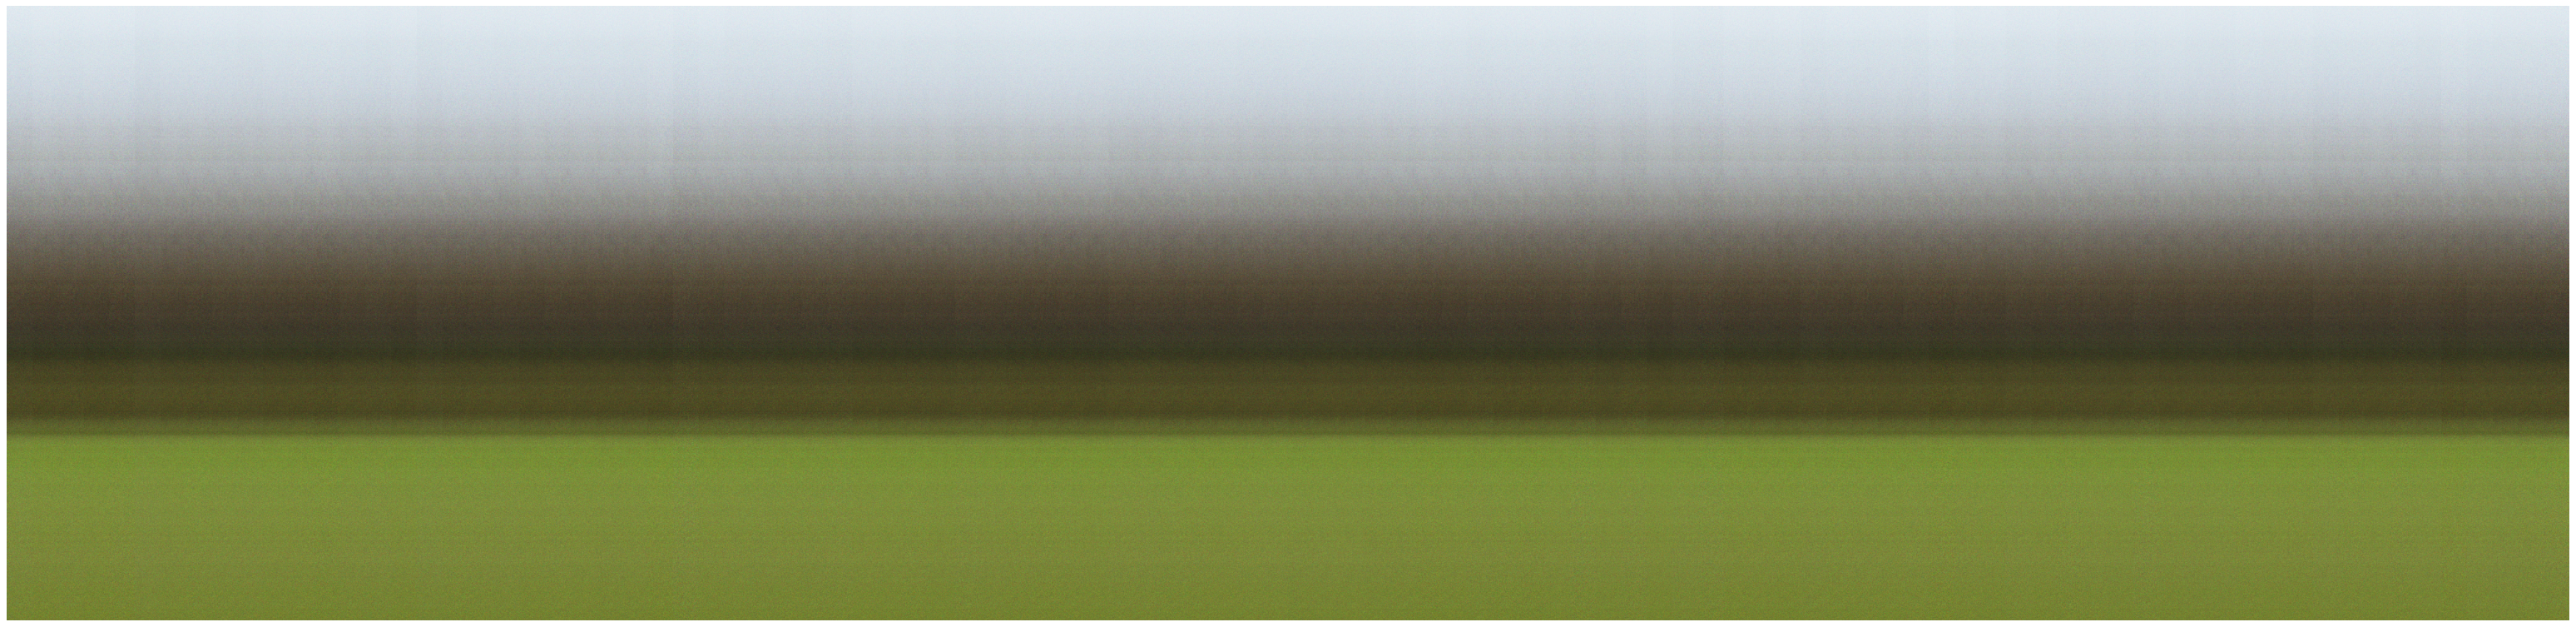

In [13]:
stitch_and_show_images(generated_images)

In [14]:
with torch.no_grad():
    noise = torch.randn(SLICES, latent_size).to(DEVICE)
    trace = torch.jit.trace(training_model.decoder, noise)
    torch.jit.save(trace, 'out/model_basic_decoder.pt')